In [1]:
#%load_ext autoreload
#%autoreload 2

# Pozo Harmónico

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
from tqdm import tqdm

In [3]:
# Matplotlib options
#%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

# Definición del Sistema

In [4]:
system = mm.System()
mass = (12.010*15.999)/(12.010+15.999) * unit.amu # masa reducidad de la molecular diatómica: C-O
system.addParticle(mass)

0

# Paisaje Energía Potencial

In [5]:
force = mm.CustomExternalForce('(K/2.0) * (x^2 + y^2 + z^2)')
K = 100.0 * unit.kilocalories_per_mole/unit.angstrom**2
force.addGlobalParameter('K', K)
force.addParticle(0, [])
system.addForce(force)

0

# Estado termodinámico

In [6]:
# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin
pressure    = None

# Parámetros de la simulación

In [7]:
step_size       = 0.001*unit.picoseconds
num_steps       = 1000000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

# Integrador

In [8]:
friction   = 1.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Plataforma de simulación

In [9]:
platform_name = 'CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"
# for ii in range(mm.Platform.getNumPlatforms()):
#     print(mm.Platform.getPlatform(ii).getName())
platform = mm.Platform.getPlatformByName(platform_name)

# Reporteros y arrays de salida

In [10]:
times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

# Condiciones iniciales

In [11]:
initial_positions  = [[0.0, 0.0, 0.0]] * unit.angstroms
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

In [12]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

# Corriendo la simulación

In [13]:
for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 10000/10000 [01:38<00:00, 91.98it/s]


# Análisis de resultados

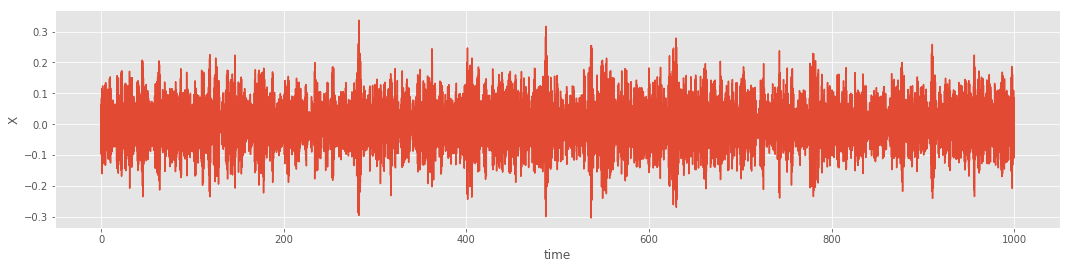

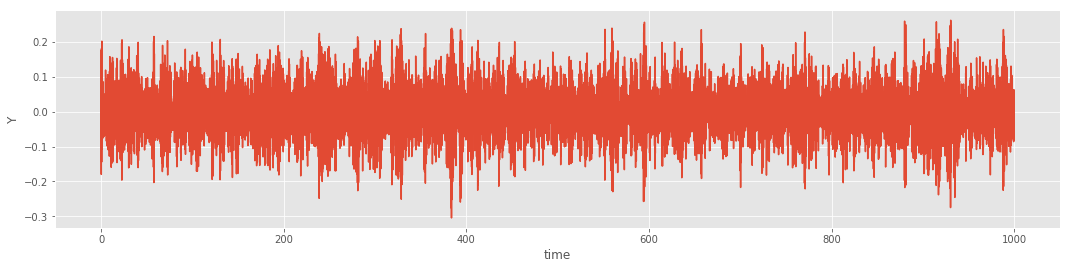

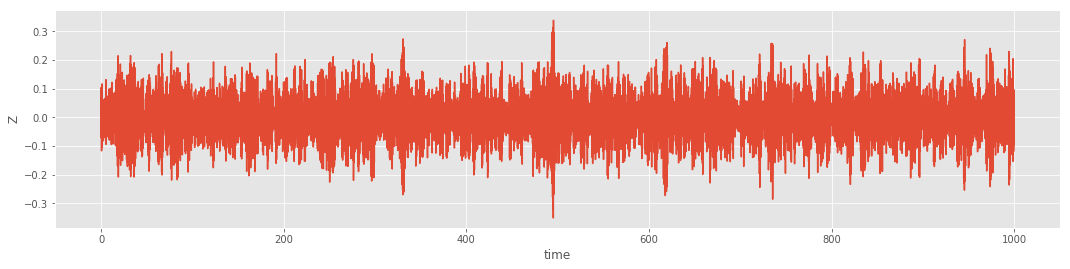

In [14]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

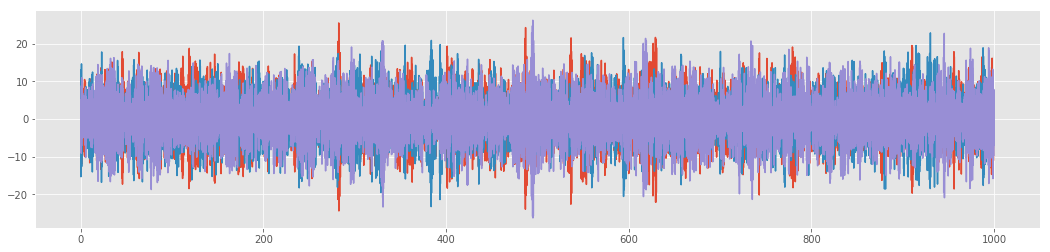

In [15]:
plt.plot(times,velocities)

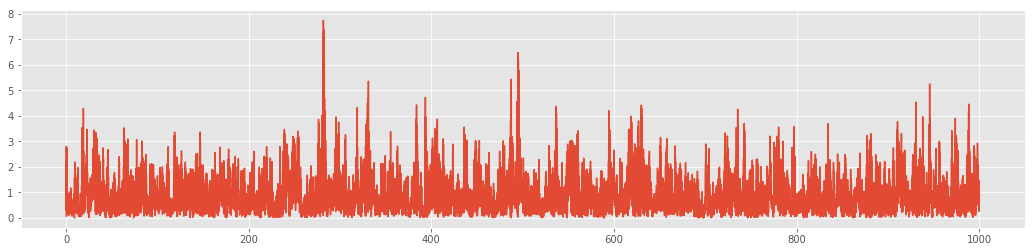

In [16]:
plt.plot(times,kinetic_energies)

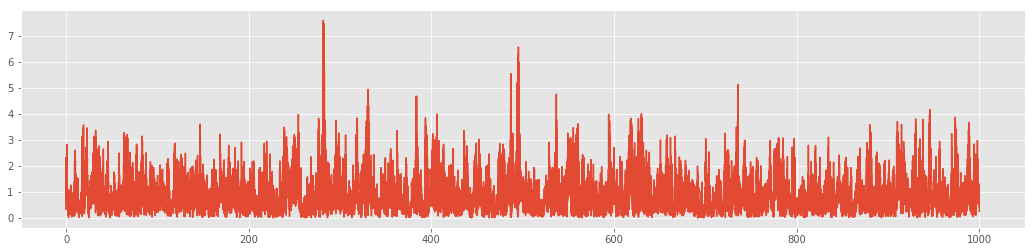

In [17]:
plt.plot(times,potential_energies)

T = sqrt(m/K) timestep smaller than ~ T/10 standard deviation in each dimension sigma= (kT / K)^(1/2) Expectation and standard deviation of the potential energy of a 3D harmonic oscillator is (3/2)kT